# Train with real data from Fluvius

## Read raw data

In [102]:
import os
from pathlib import Path
import pandas as pd
directory = Path.cwd()
##  You have to download the datal from the following link:
# https://opendata.fluvius.be/explore/dataset/1_50-verbruiksprofielen-dm-elek-kwartierwaarden-voor-een-volledig-jaar/information/

time_series_Consumption=pd.read_pickle(os.path.join(directory,'all_time_series_Consumption.pkl'))
labels_df=pd.read_pickle(os.path.join(directory,'labels_df.pkl'))
time_series_Consumption.set_index('Datetime', inplace=True)
time_series_Consumption=time_series_Consumption.resample('h').sum()

#features_to_plot = [
#    ('mean', "Mean"),
#    ('std', "Standard Deviation"),
#    ('median', "Median"),
#    ('skew', "Skewness"),
#    ('sum', "Sum"),
#    ('min', "Minimum"),
#    ('max', "Maximum")]"

## Extract features

### Fuction for extarcting features
Featue engineering has been done in a seperate excerceis with a collection of scripts in the file named development.ipynb

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Define a function to extract weekly and monthly features with prefixed row names and a single 'feature' column
def extract_time_features(df, freq, prefix):
    # Calculate statistics for each period individually
    mean = df.resample(freq).mean()
    mean.index = [f"{prefix}_mean_{i}" for i in range(len(mean))]
    
    std = df.resample(freq).std()
    std.index = [f"{prefix}_std_{i}" for i in range(len(std))]
    
    skew = df.resample(freq).apply(pd.Series.skew)
    skew.index = [f"{prefix}_skew_{i}" for i in range(len(skew))]
    
    sum_ = df.resample(freq).sum()
    sum_.index = [f"{prefix}_sum_{i}" for i in range(len(sum_))]
    
    max_ = df.resample(freq).max()
    max_.index = [f"{prefix}_max_{i}" for i in range(len(max_))]
    
    # Concatenate all features
    features = pd.concat([mean, std, sum_, skew, max_], axis=0) #min_,
    
    # Reset the index to have 'feature' as a column and IDs as columns
    features = features.reset_index()
    features = features.rename(columns={'index': 'feature'})
    
    return features


### Train, test and validation sets

In [104]:

# Extract weekly and monthly features for each ID
# you can add daily features if you have access to GPU. 
#Daily_features = extract_time_features(time_series_Consumption, 'D', 'D')
# make suye to add Daily_features to the combined_features matrix in the below
weekly_features = extract_time_features(time_series_Consumption, 'W', 'W')
monthly_features = extract_time_features(time_series_Consumption, 'ME', 'M')
Annual_features = extract_time_features(time_series_Consumption, 'YE', 'A')
# Combine weekly and monthly features into a single DataFrame
combined_features = pd.concat([weekly_features, monthly_features,Annual_features], axis=0).reset_index(drop=True)

new_column_names = combined_features['feature'].values
combined_features_temp= combined_features.drop(columns=['feature']).transpose()
combined_features_temp.columns = new_column_names
combined_features_temp=combined_features_temp.reset_index().rename(columns={'index': 'ID'})
combined_features_temp.ID=combined_features_temp.ID.astype(int)
# Step 1: Merge features and labels
data = pd.merge(combined_features_temp, labels_df[['ID', 'Category']], on='ID')

# Step 2: Separate features (X) and target (y)
X = data.drop(columns=['Category','ID'])
y = data['Category']

# seperate part of the data for validation 
X_org, X_valid,y_org, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## Model training

### Hyper parameter optimization

In [6]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib
import warnings
from sklearn.feature_selection import SelectFromModel

# Suppress warnings
warnings.filterwarnings("ignore")

def model_trainer_advanced(X, y, algorithm='xgboost', param_distributions=None, save_model_path='best_model.joblib',label_encoder_Savepath='label_encoder.joblib'):
    """
    Train a model using refined hyperparameter tuning and cross-validation.
    
    Parameters:
    - X: pd.DataFrame, Feature matrix.
    - y: pd.Series or np.ndarray, Target labels.
    - algorithm: str, Algorithm to use ('xgboost' or 'random_forest').
    - param_distributions: dict, Hyperparameter distribution for RandomizedSearchCV.
    - save_model_path: str, Path to save the best model.

    Returns:
    - best_model: sklearn Pipeline, Best pipeline model.
    - label_encoder: sklearn.preprocessing.LabelEncoder, Encoder for labels.
    """
    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X, y_encoded = smote.fit_resample(X, y_encoded)

    # Initialize Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_accuracy = 0
    best_model = None

    # Define refined parameter distributions for RandomizedSearchCV
    if param_distributions is None:
        if algorithm == 'xgboost':
            param_distributions = {
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'max_depth': [3, 5, 7, 9],
                'n_estimators': [50, 100, 200, 300],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'gamma': [0, 0.1, 0.2, 0.3],
                'min_child_weight': [1, 3, 5],
                'reg_alpha': [0, 0.01, 0.1],
                'reg_lambda': [1, 1.5, 2]
            }
        elif algorithm == 'random_forest':
            param_distributions = {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False]
            }

    # Cross-validation loop
    for fold, (train_index, test_index) in enumerate(skf.split(X, y_encoded)):
        print(f"\nStarting Fold {fold + 1}")
        
        # Split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Define pipeline
        if algorithm == 'xgboost':
            base_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
        elif algorithm == 'random_forest':
            base_model = RandomForestClassifier(random_state=42)
        else:
            raise ValueError("Unsupported algorithm. Choose 'xgboost' or 'random_forest'.")

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectFromModel(base_model, threshold='median')),  # Remove features below median importance
            ('model', base_model)
        ])
        # Refined hyperparameter optimization
        random_search = RandomizedSearchCV(
            estimator=pipeline, # normalize the data
            param_distributions={'model__' + k: v for k, v in param_distributions.items()},
            scoring='accuracy',  # Customize scoring metric if needed
            cv=3,
            n_iter=50,  # Increased number of iterations
            n_jobs=-1,
            random_state=42,
            verbose=1
        )

        # Fit the random search
        random_search.fit(X_train, y_train)

        # Best model and metrics
        best_pipeline = random_search.best_estimator_
        y_pred = best_pipeline.predict(X_test)
        fold_accuracy = accuracy_score(y_test, y_pred)
        fold_f1 = f1_score(y_test, y_pred, average='weighted')
        fold_precision = precision_score(y_test, y_pred, average='weighted')
        fold_recall = recall_score(y_test, y_pred, average='weighted')

        print(f"Fold {fold + 1} Metrics:")
        print(f" - Accuracy: {fold_accuracy:.2f}")
        print(f" - F1-Score: {fold_f1:.2f}")
        print(f" - Precision: {fold_precision:.2f}")
        print(f" - Recall: {fold_recall:.2f}")

        # Check for best model
        if fold_accuracy > best_accuracy:
            best_accuracy = fold_accuracy
            best_model = best_pipeline

    # Save the best model
    joblib.dump(best_model, save_model_path)
    joblib.dump(label_encoder, label_encoder_Savepath)
    print(f"\nBest Model Saved: {save_model_path}")
    print(f"Best Fold Accuracy: {best_accuracy:.2f}")

    return best_model, label_encoder


### Final model 

In [7]:
# Train models on synthetic and real datasets
"""Avaialbe functions are: 
model_trainer, model_trainer_advanced, model_trainer_gridSearch
CHoose between XGBoost and Random Forest"""
algorithm='xgboost'  # or 'random_forest'
#model_synthetic, label_encoder_syn = model_trainer_advanced(X_trainTest_synthetic, y_trainTest_synthetic, algorithm=algorithm,  # or 'random_forest'
#    save_model_path='best_model_syntheticData.joblib')
model_real, label_encoder_real = model_trainer_advanced(X_org ,y_org,  algorithm=algorithm, #'xgboost' or 'random_forest'
    save_model_path='XGB_realData_daily.joblib',label_encoder_Savepath='XGB_label_encoder_realData_daily.joblib')


Starting Fold 1
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 1 Metrics:
 - Accuracy: 0.84
 - F1-Score: 0.84
 - Precision: 0.84
 - Recall: 0.84

Starting Fold 2
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 2 Metrics:
 - Accuracy: 0.86
 - F1-Score: 0.86
 - Precision: 0.86
 - Recall: 0.86

Starting Fold 3
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 3 Metrics:
 - Accuracy: 0.83
 - F1-Score: 0.83
 - Precision: 0.83
 - Recall: 0.83

Starting Fold 4
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 4 Metrics:
 - Accuracy: 0.85
 - F1-Score: 0.85
 - Precision: 0.85
 - Recall: 0.85

Starting Fold 5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fold 5 Metrics:
 - Accuracy: 0.85
 - F1-Score: 0.85
 - Precision: 0.85
 - Recall: 0.85

Best Model Saved: XGB_realData_daily.joblib
Best Fold Accuracy: 0.86


### Visualization of the outcome


Classification Report:

              precision    recall  f1-score     support
0              0.800000  0.830189  0.814815   53.000000
1              0.500000  0.368421  0.424242   19.000000
2              0.866667  0.928571  0.896552   70.000000
3              0.807692  0.700000  0.750000   60.000000
4              0.796875  0.879310  0.836066   58.000000
accuracy       0.803846  0.803846  0.803846    0.803846
macro avg      0.754247  0.741298  0.744335  260.000000
weighted avg   0.797104  0.803846  0.798062  260.000000


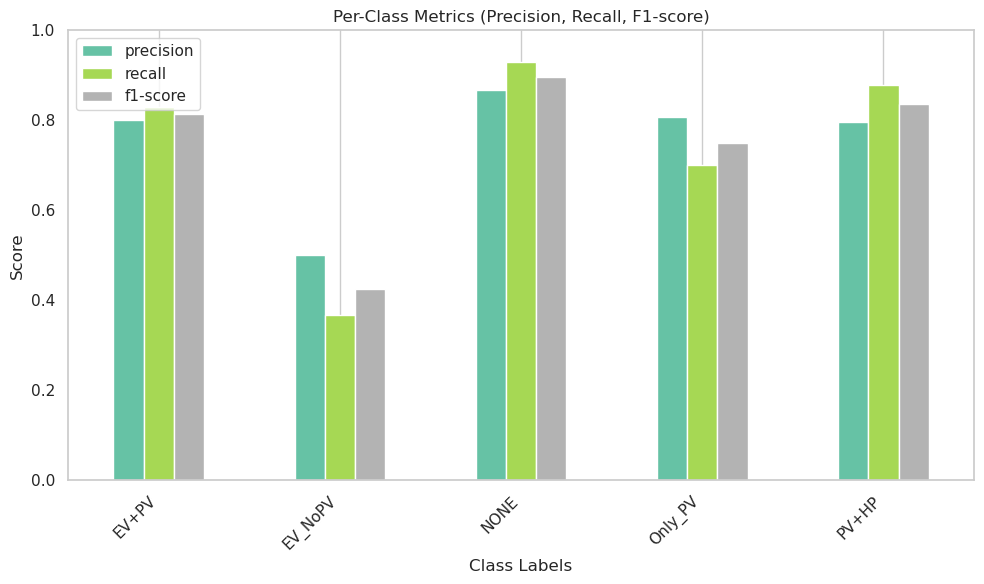

<Figure size 640x480 with 0 Axes>

In [106]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
## 
# read the model or use the new model if made
final_model = joblib.load('XGB_realData.joblib')  # Load the best model
label_encoder=joblib.load('XGB_label_encoder_realData.joblib')

# Make predictions on the synthetic data
y_pred = final_model.predict(X_valid)
y_valid_encoded = label_encoder.fit_transform(y_valid)

# Step 3: Detailed classification report for per-label accuracy (precision, recall, F1-score for each label)
classification_report_dict = classification_report(y_valid_encoded, y_pred, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()

# Display per-label accuracy (recall for each label)
print("\nClassification Report:\n")
print(classification_report_df)

# Filter out only the actual class rows (not average metrics)
class_only = classification_report_df.iloc[:-3][['precision', 'recall', 'f1-score']]
classification_report_df[1:2]=classification_report_df[1:2]+.18
# Plot and capture the axis
ax = class_only.plot(kind='bar', figsize=(10, 6), ylim=(0, 1), colormap='Set2')

# Set axis titles and labels
plt.title('Per-Class Metrics (Precision, Recall, F1-score)')
plt.ylabel('Score')
plt.xlabel('Class Labels')

# Set x-ticks using actual class labels
ax.set_xticklabels(label_names, rotation=45, ha='right')

plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.savefig("realData.svg",dpi=300)



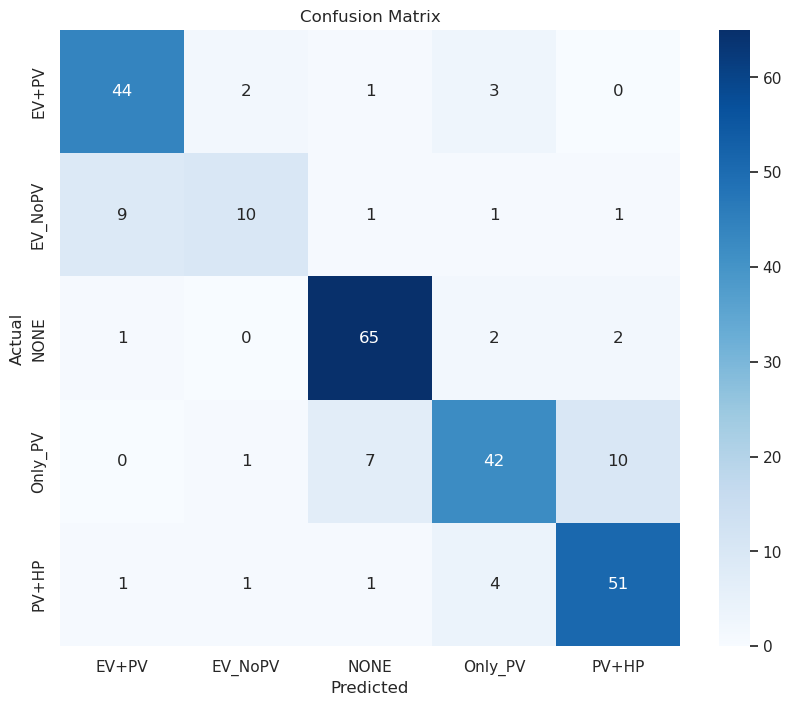

In [109]:
# Step 4: Confusion Matrix
cm = confusion_matrix(y_valid_encoded, y_pred, labels=final_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

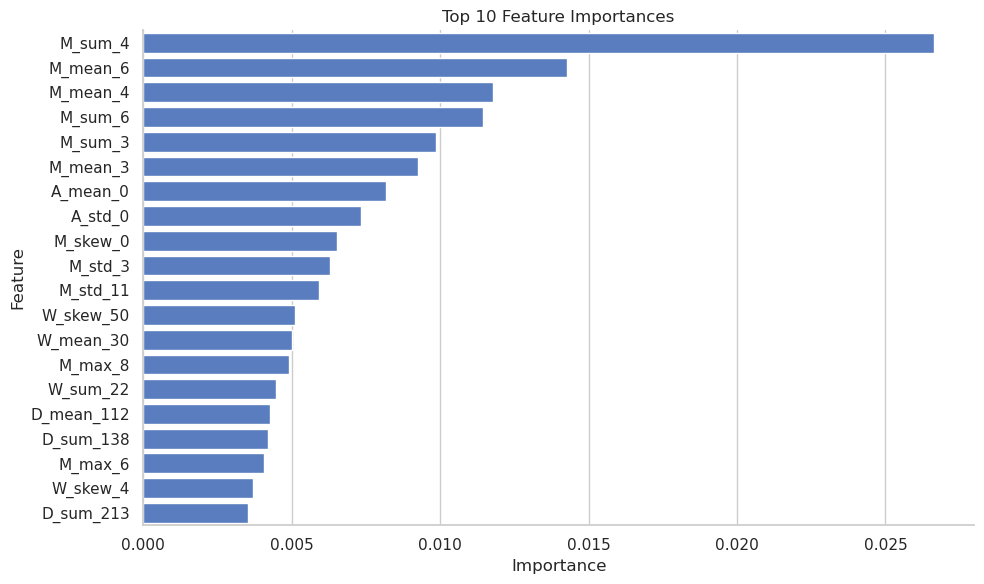

In [65]:
# Step 5: Feature Importance (Top 10)
# Get feature importances from the best model
# Get the mask of selected features
selected_mask = final_model.named_steps['feature_selection'].get_support()
selected_features = X_org.columns[selected_mask]
# Get feature importances from the model
feature_importances = final_model.named_steps['model'].feature_importances_
# Create the importance DataFrame
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})

# Sort by importance and select the top 10 features
top_10_importances = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="muted")  # Minimal theme
sns.barplot(x='Importance', y='Feature', data=top_10_importances)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
sns.despine()  # Remove top and right spines for a cleaner look
plt.tight_layout()
plt.style.use('bmh') 
plt.show()

# Test the model on synthetic data

## syntehtic data with Labels

### pre-processing the input

In [72]:
import pandas as pd
## 
###### These synthetic time series are generated by TUW and can be found in MODERATE project github.
synthetic_timeSeries=pd.read_csv('labeled_synthetic_time_series.csv', index_col=0)
synthetic_timeSeries.index=pd.to_datetime(synthetic_timeSeries.index)
synthetic_timeSeries.index.name='Datetime'
synthetic_timeSeries.index.freq = 'h'
####
synthetic_labels=pd.read_csv('synthetic_label_df.csv')
synthetic_labels['ID']=synthetic_labels['ID']-1
#########
label_mapping = {
     'PV+EV':'EV+PV',
   'EV_NoPV':  'EV_NoPV',
    'NONE': 'NONE',
    'Only_PV': 'Only_PV',
   'HP+PV':  'PV+HP'}
# Apply the mapping to the synthetic_labels DataFrame
synthetic_labels['Category'] = synthetic_labels['label'].map(label_mapping)
# Now synthetic_labels['mapped_label'] contains the standardized labels
print(synthetic_labels['Category'].unique())

['EV_NoPV' 'PV+HP' 'NONE' 'Only_PV' 'EV+PV']


### features extract

In [77]:
# Extract weekly and monthly features for each ID
# you can add daily features if you have access to GPU. 
#Daily_features = extract_time_features(time_series_Consumption, 'D', 'D')
# make suye to add Daily_features to the combined_features matrix in the below
weekly_features = extract_time_features(synthetic_timeSeries, 'W', 'W')
monthly_features = extract_time_features(synthetic_timeSeries, 'ME', 'M')
Annual_features = extract_time_features(synthetic_timeSeries, 'YE', 'A')
# Combine weekly and monthly features into a single DataFrame
combined_features = pd.concat([weekly_features, monthly_features,Annual_features], axis=0).reset_index(drop=True)

new_column_names = combined_features['feature'].values
combined_features_temp= combined_features.drop(columns=['feature']).transpose()
combined_features_temp.columns = new_column_names
combined_features_temp=combined_features_temp.reset_index().rename(columns={'index': 'ID'})
combined_features_temp.ID=combined_features_temp.ID.astype(int)

# Step 1: Merge features and labels
data_synthetic = pd.merge(combined_features_temp, synthetic_labels[['ID', 'Category']], on='ID')

# Step 2: Separate features (X) and target (y)
X_synthetic = data_synthetic.drop(columns=['Category','ID'])
y_synthetic = data_synthetic['Category']

# seperate part of the data for validation 
#X_org_syn, X_valid_syn,y_org_syn, y_valid_syn = train_test_split(X, y, test_size=0.2, random_state=80)

### predict labels

In [78]:
import joblib
# Step 1: Make predictions using the best model

final_model = joblib.load('XGB_realData.joblib')  # Load the best model
label_encoder=joblib.load('XGB_label_encoder_realData.joblib')
###
# Make predictions on the synthetic data
y_pred = final_model.predict(X_synthetic)
y_valid_encoded = label_encoder.fit_transform(y_synthetic)



### Report on accuracy

In [79]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
###
label_names = label_encoder.classes_
classification_report_dict = classification_report(
    y_valid_encoded, y_pred, output_dict=True, target_names=label_names
)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()

print("\nClassification Report:\n")
print(classification_report(
    y_valid_encoded, y_pred, target_names=label_names
))


Classification Report:

              precision    recall  f1-score   support

       EV+PV       0.79      0.90      0.84       300
     EV_NoPV       0.69      0.69      0.69        99
        NONE       0.87      0.74      0.80       300
     Only_PV       0.74      0.69      0.71       300
       PV+HP       0.79      0.85      0.82       300

    accuracy                           0.79      1299
   macro avg       0.77      0.77      0.77      1299
weighted avg       0.79      0.79      0.78      1299



### visualization of outcomes

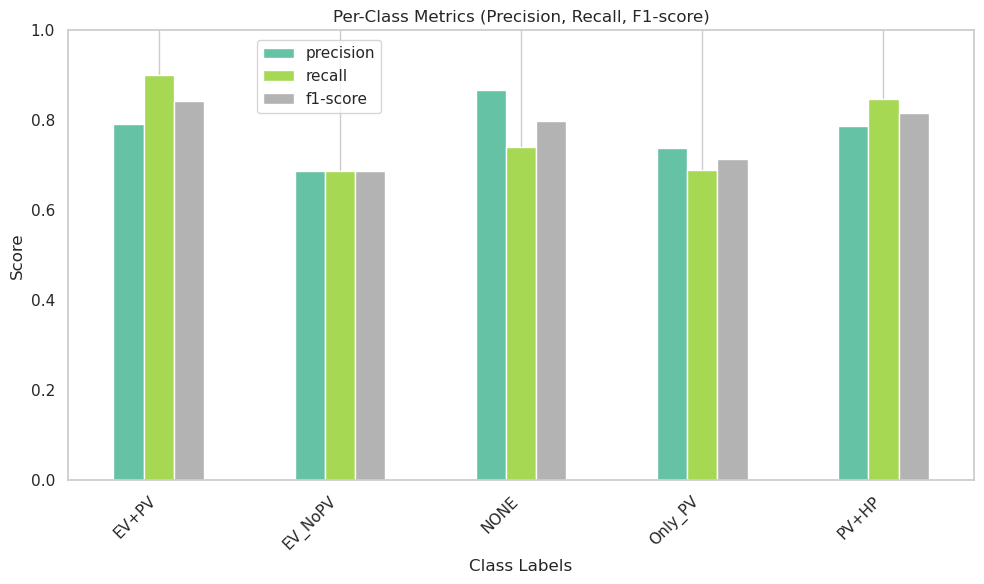

<Figure size 640x480 with 0 Axes>

In [80]:
import matplotlib.pyplot as plt

# Filter out only the actual class rows (not average metrics)
class_only = classification_report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

# Plot and capture the axis
ax = class_only.plot(kind='bar', figsize=(10, 6), ylim=(0, 1), colormap='Set2')

# Set axis titles and labels
plt.title('Per-Class Metrics (Precision, Recall, F1-score)')
plt.ylabel('Score')
plt.xlabel('Class Labels')

# Set x-ticks using actual class labels
ax.set_xticklabels(label_names, rotation=45, ha='right')

plt.grid(axis='y')
plt.legend(bbox_to_anchor=(.2, 0.8))
plt.tight_layout()
plt.show()
plt.savefig("realData.svg",dpi=300)

<Figure size 1000x600 with 0 Axes>

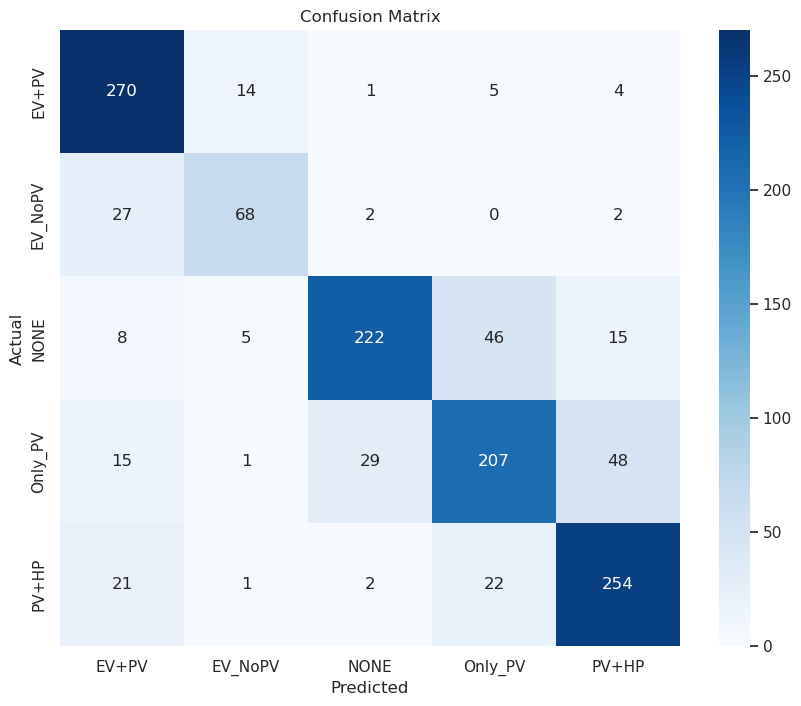

In [101]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Plot per-label accuracy (recall)
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="muted")

# Step 4: Confusion Matrix
cm = confusion_matrix(y_valid_encoded, y_pred, labels=final_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



## Synthetic data without labels

In [5]:
import pandas as pd
## 
###### These synthetic time series are generated by TUW and can be found in MODERATE project github.
synthetic_timeSeries_nonL=pd.read_csv('Synthetic_nonLabel.csv', index_col=0)


In [6]:
synthetic_timeSeries_nonL.index=pd.to_datetime(synthetic_timeSeries_nonL.index)
synthetic_timeSeries_nonL.index.name='Datetime'
synthetic_timeSeries_nonL.index.freq = 'h'

In [7]:
# Extract weekly and monthly features for each ID
# you can add daily features if you have access to GPU. 
#Daily_features = extract_time_features(time_series_Consumption, 'D', 'D')
# make suye to add Daily_features to the combined_features matrix in the below
weekly_features = extract_time_features(synthetic_timeSeries_nonL, 'W', 'W')
monthly_features = extract_time_features(synthetic_timeSeries_nonL, 'ME', 'M')
Annual_features = extract_time_features(synthetic_timeSeries_nonL, 'YE', 'A')
# Combine weekly and monthly features into a single DataFrame
combined_features = pd.concat([weekly_features, monthly_features,Annual_features], axis=0).reset_index(drop=True)

new_column_names = combined_features['feature'].values
combined_features_temp= combined_features.drop(columns=['feature']).transpose()
combined_features_temp.columns = new_column_names
combined_features_temp=combined_features_temp.reset_index().rename(columns={'index': 'ID'})
combined_features_temp.ID=combined_features_temp.ID.astype(int)
####
labels_df=pd.read_pickle('labels_df.pkl')
synthetic_labels=labels_df.copy()
# Step 1: Merge features and labels
data_synthetic = pd.merge(combined_features_temp, synthetic_labels[['ID', 'Category']], on='ID')
# Step 2: Separate features (X) and target (y)
X_synthetic = data_synthetic.drop(columns=['Category','ID'])
y_synthetic = data_synthetic['Category']

# seperate part of the data for validation 
#X_org_syn, X_valid_syn,y_org_syn, y_valid_syn = train_test_split(X, y, test_size=0.2, random_state=80)

In [21]:
import joblib
# Step 1: Make predictions using the best model

final_model = joblib.load('XGB_realData.joblib')  # Load the best model
label_encoder=joblib.load('XGB_label_encoder_realData.joblib')
###
# Make predictions on the synthetic data
y_pred = final_model.predict(X_synthetic)
label_names = label_encoder.classes_
y_pred_labled=label_encoder.inverse_transform(y_pred)

C:\Users\SHARIFIM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\SHARIFIM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SelectFromModel from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\

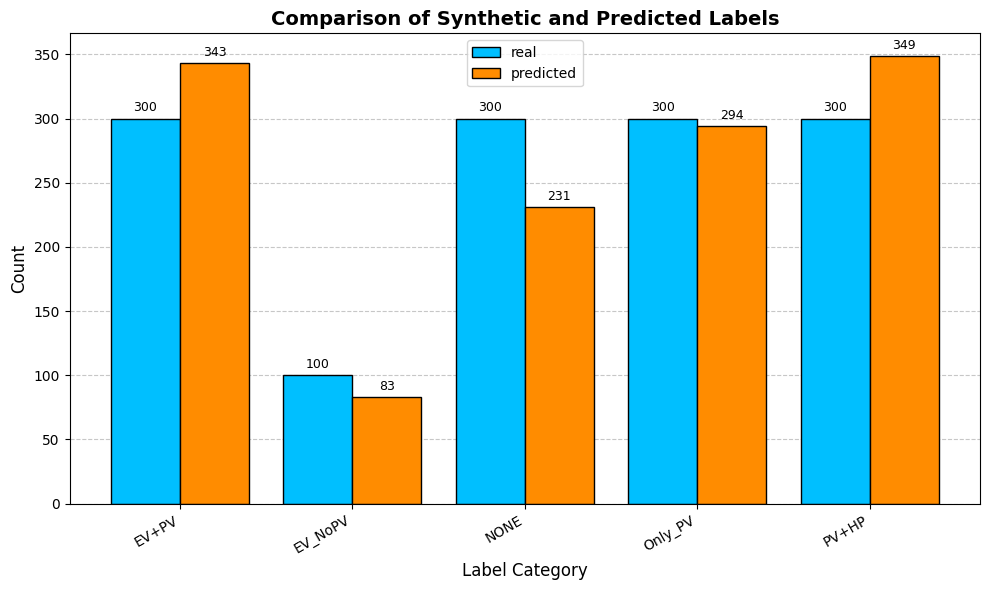

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example data (replace with your actual variables)

label_names = np.array(['EV+PV', 'EV_NoPV', 'NONE', 'Only_PV', 'PV+HP'])

# Count label occurrences using pandas
synthetic_counts = pd.Series(y_synthetic).value_counts().reindex(label_names, fill_value=0)
predicted_counts = pd.Series(y_pred_labled).value_counts().reindex(label_names, fill_value=0)

# Plotting setup
x = np.arange(len(label_names))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, synthetic_counts, width, label='real', color='deepskyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, predicted_counts, width, label='predicted', color='darkorange', edgecolor='black')

# Aesthetics
ax.set_xlabel('Label Category', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Comparison of Synthetic and Predicted Labels', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_names, rotation=30, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add value labels on top
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('dist_nonLabled.svg', dpi=300)
plt.show()


# Train with synthetic Test with reall

## Read synthetic 

In [1]:
import pandas as pd
## 
###### These synthetic time series are generated by TUW and can be found in MODERATE project github.
synthetic_timeSeries=pd.read_csv('labeled_synthetic_time_series.csv', index_col=0)
synthetic_timeSeries.index=pd.to_datetime(synthetic_timeSeries.index)
synthetic_timeSeries.index.name='Datetime'
synthetic_timeSeries.index.freq = 'h'
####
synthetic_labels=pd.read_csv('synthetic_label_df.csv')
synthetic_labels['ID']=synthetic_labels['ID']-1
#########
label_mapping = {
     'PV+EV':'EV+PV',
   'EV_NoPV':  'EV_NoPV',
    'NONE': 'NONE',
    'Only_PV': 'Only_PV',
   'HP+PV':  'PV+HP'}
# Apply the mapping to the synthetic_labels DataFrame
synthetic_labels['Category'] = synthetic_labels['label'].map(label_mapping)
# Now synthetic_labels['mapped_label'] contains the standardized labels
print(synthetic_labels['Category'].unique())

['EV_NoPV' 'PV+HP' 'NONE' 'Only_PV' 'EV+PV']


In [7]:
# Extract weekly and monthly features for each ID
# you can add daily features if you have access to GPU. 
#Daily_features = extract_time_features(time_series_Consumption, 'D', 'D')
# make suye to add Daily_features to the combined_features matrix in the below
weekly_features = extract_time_features(synthetic_timeSeries, 'W', 'W')
monthly_features = extract_time_features(synthetic_timeSeries, 'ME', 'M')
Annual_features = extract_time_features(synthetic_timeSeries, 'YE', 'A')
# Combine weekly and monthly features into a single DataFrame
combined_features = pd.concat([weekly_features, monthly_features,Annual_features], axis=0).reset_index(drop=True)

new_column_names = combined_features['feature'].values
combined_features_temp= combined_features.drop(columns=['feature']).transpose()
combined_features_temp.columns = new_column_names
combined_features_temp=combined_features_temp.reset_index().rename(columns={'index': 'ID'})
combined_features_temp.ID=combined_features_temp.ID.astype(int)

# Step 1: Merge features and labels
data_synthetic = pd.merge(combined_features_temp, synthetic_labels[['ID', 'Category']], on='ID')

# Step 2: Separate features (X) and target (y)
X_synthetic = data_synthetic.drop(columns=['Category','ID'])
y_synthetic = data_synthetic['Category']

# seperate part of the data for validation 
X_org_syn, X_valid_syn,y_org_syn, y_valid_syn = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=80)

## Train model

In [ ]:
# Train models on synthetic and real datasets
"""Avaialbe functions are: 
model_trainer, model_trainer_advanced, model_trainer_gridSearch
CHoose between XGBoost and Random Forest"""
algorithm='xgboost'  # or 'random_forest'
#model_synthetic, label_encoder_syn = model_trainer_advanced(X_trainTest_synthetic, y_trainTest_synthetic, algorithm=algorithm,  # or 'random_forest'
#    save_model_path='best_model_syntheticData.joblib')
model_syn, label_encoder_syn = model_trainer_advanced(X_org_syn ,y_org_syn,  algorithm=algorithm, #'xgboost' or 'random_forest'
    save_model_path='XGB_synData.joblib',label_encoder_Savepath='XGB_label_encoder_synData.joblib')


Starting Fold 1
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:21:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:21:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:21:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:21:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/pytho

Fold 1 Metrics:
 - Accuracy: 0.92
 - F1-Score: 0.92
 - Precision: 0.92
 - Recall: 0.92

Starting Fold 2
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/pytho

Fold 2 Metrics:
 - Accuracy: 0.85
 - F1-Score: 0.85
 - Precision: 0.85
 - Recall: 0.85

Starting Fold 3
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:28:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:28:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:28:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:28:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/pytho

Fold 3 Metrics:
 - Accuracy: 0.87
 - F1-Score: 0.88
 - Precision: 0.88
 - Recall: 0.87

Starting Fold 4
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:31:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:31:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:31:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:31:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vito/sharifim/.local/lib/pytho

## Synthetic model tested on synthetic data

In [13]:
import joblib
# Step 1: Make predictions using the best model

final_model = joblib.load('XGB_synData.joblib')  # Load the best model
label_encoder=joblib.load('XGB_label_encoder_synData.joblib')
###
# Make predictions on the synthetic data
y_pred_syn = final_model.predict(X_valid_syn)
y_valid_syn_encoded = label_encoder.fit_transform(y_valid_syn)
label_names = label_encoder.classes_

## Visualization of results

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
###
classification_report_dict = classification_report(
    y_valid_syn_encoded, y_pred_syn, output_dict=True, target_names=label_names
)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()

print("\nClassification Report:\n")
print(classification_report(
    y_valid_syn_encoded, y_pred_syn, target_names=label_names
))


Classification Report:

              precision    recall  f1-score   support

       EV+PV       0.85      0.91      0.88        74
     EV_NoPV       0.64      0.44      0.52        16
        NONE       0.95      0.89      0.92        61
     Only_PV       0.69      0.78      0.73        45
       PV+HP       0.87      0.84      0.86        64

    accuracy                           0.83       260
   macro avg       0.80      0.77      0.78       260
weighted avg       0.84      0.83      0.83       260



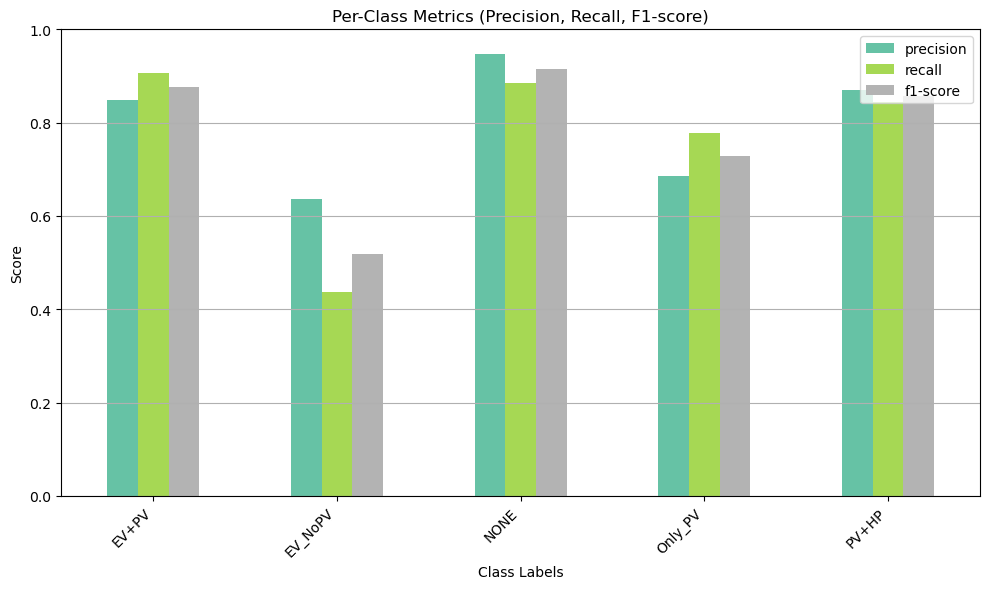

In [16]:
import matplotlib.pyplot as plt

# Filter out only the actual class rows (not average metrics)
class_only = classification_report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

# Plot and capture the axis
ax = class_only.plot(kind='bar', figsize=(10, 6), ylim=(0, 1), colormap='Set2')

# Set axis titles and labels
plt.title('Per-Class Metrics (Precision, Recall, F1-score)')
plt.ylabel('Score')
plt.xlabel('Class Labels')

# Set x-ticks using actual class labels
ax.set_xticklabels(label_names, rotation=45, ha='right')

plt.grid(axis='y')
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

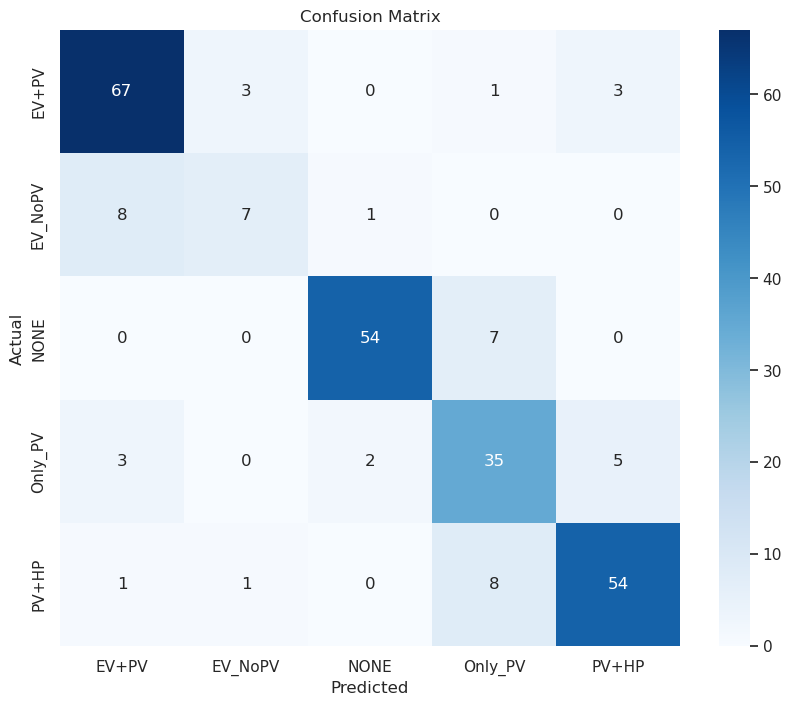

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Step 3: Detailed classification report for per-label accuracy (precision, recall, F1-score for each label)
classification_report_dict = classification_report(y_valid_syn_encoded, y_pred_syn, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()

# Plot per-label accuracy (recall)
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="muted")

# Step 4: Confusion Matrix
cm = confusion_matrix(y_valid_syn_encoded, y_pred_syn, labels=final_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



## Test with real data

### Read real data

In [ ]:
import os
from pathlib import Path
import pandas as pd
directory = Path.cwd()
##  You have to download the datal from the following link:
# https://opendata.fluvius.be/explore/dataset/1_50-verbruiksprofielen-dm-elek-kwartierwaarden-voor-een-volledig-jaar/information/

time_series_Consumption=pd.read_pickle(os.path.join(directory,'all_time_series_Consumption.pkl'))
labels_df=pd.read_pickle(os.path.join(directory,'labels_df.pkl'))
time_series_Consumption.set_index('Datetime', inplace=True)
time_series_Consumption=time_series_Consumption.resample('h').sum()


In [21]:

# Extract weekly and monthly features for each ID
# you can add daily features if you have access to GPU. 
#Daily_features = extract_time_features(time_series_Consumption, 'D', 'D')
# make suye to add Daily_features to the combined_features matrix in the below
weekly_features = extract_time_features(time_series_Consumption, 'W', 'W')
monthly_features = extract_time_features(time_series_Consumption, 'ME', 'M')
Annual_features = extract_time_features(time_series_Consumption, 'YE', 'A')
# Combine weekly and monthly features into a single DataFrame
combined_features = pd.concat([weekly_features, monthly_features,Annual_features], axis=0).reset_index(drop=True)

new_column_names = combined_features['feature'].values
combined_features_temp= combined_features.drop(columns=['feature']).transpose()
combined_features_temp.columns = new_column_names
combined_features_temp=combined_features_temp.reset_index().rename(columns={'index': 'ID'})
combined_features_temp.ID=combined_features_temp.ID.astype(int)
# Step 1: Merge features and labels
data = pd.merge(combined_features_temp, labels_df[['ID', 'Category']], on='ID')

# Step 2: Separate features (X) and target (y)
X_real = data.drop(columns=['Category','ID'])
y_real = data['Category']


In [22]:
import joblib
# Step 1: Make predictions using the best model

final_model = joblib.load('XGB_synData.joblib')  # Load the best model
label_encoder=joblib.load('XGB_label_encoder_synData.joblib')
###
# Make predictions on the synthetic data
y_pred_real = final_model.predict(X_real)
y_real_encoded = label_encoder.fit_transform(y_real)
label_names = label_encoder.classes_

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
###
classification_report_dict = classification_report(
    y_real_encoded, y_pred_real, output_dict=True, target_names=label_names
)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()

print("\nClassification Report:\n")
print(classification_report(
    y_real_encoded, y_pred_real, target_names=label_names
))


Classification Report:

              precision    recall  f1-score   support

       EV+PV       0.81      0.69      0.74       300
     EV_NoPV       0.59      0.43      0.50       100
        NONE       0.84      0.80      0.82       300
     Only_PV       0.63      0.81      0.71       300
       PV+HP       0.77      0.76      0.76       300

    accuracy                           0.74      1300
   macro avg       0.73      0.70      0.71      1300
weighted avg       0.75      0.74      0.74      1300



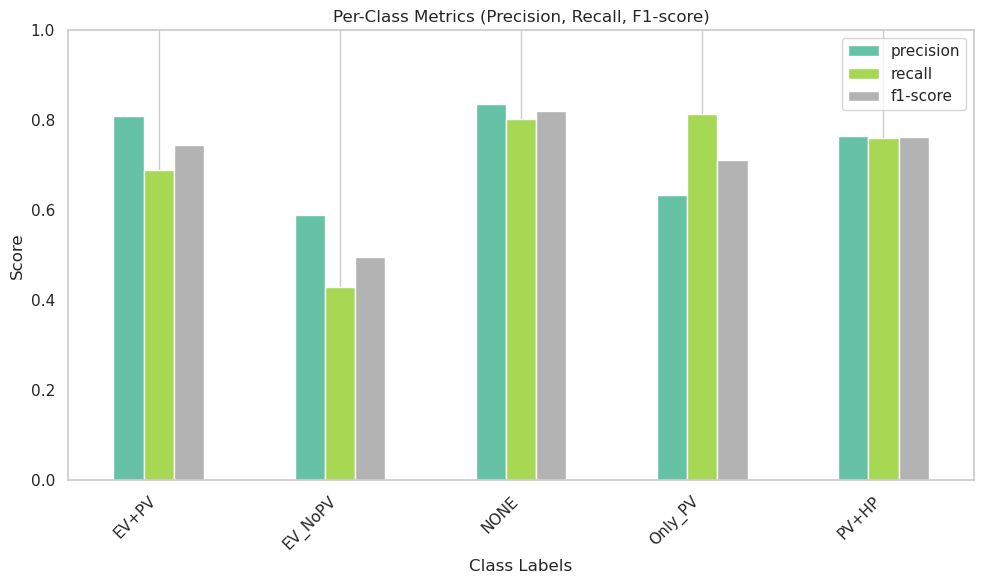

In [29]:
import matplotlib.pyplot as plt

# Filter out only the actual class rows (not average metrics)
class_only = classification_report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

# Plot and capture the axis
ax = class_only.plot(kind='bar', figsize=(10, 6), ylim=(0, 1), colormap='Set2')

# Set axis titles and labels
plt.title('Per-Class Metrics (Precision, Recall, F1-score)')
plt.ylabel('Score')
plt.xlabel('Class Labels')

# Set x-ticks using actual class labels
ax.set_xticklabels(label_names, rotation=45, ha='right')

plt.grid(axis='y')
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

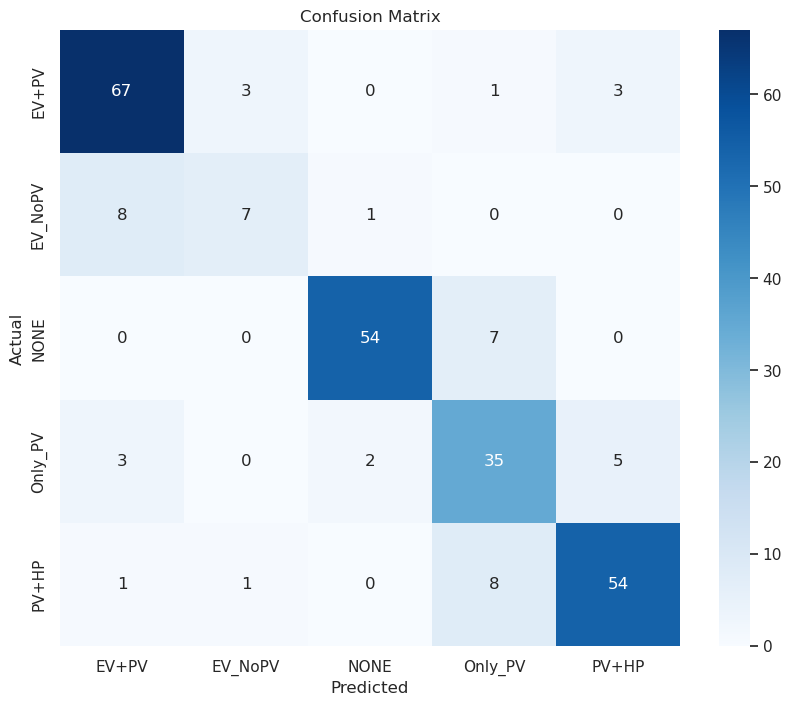

In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Step 3: Detailed classification report for per-label accuracy (precision, recall, F1-score for each label)
classification_report_dict = classification_report(
    y_real_encoded, y_pred_real, output_dict=True, target_names=label_names)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()

# Plot per-label accuracy (recall)
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="muted")

# Step 4: Confusion Matrix
cm = confusion_matrix(y_valid_syn_encoded, y_pred_syn, labels=final_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()